Author: Micheal C. Chen

Email: muchuchen03@gmail.com

# Task 1

In this task, we will write a program to diagonalize the **extended Hubbard model** on a **6-site ladder**.

$$
H = -t \sum_{\langle i,j\rangle,\sigma}\big(c^{\dagger}_{i\sigma}c_{j\sigma}+c^{\dagger}_{j\sigma}c_{i\sigma}\big)
+ U\sum_{i} n_{i\uparrow}n_{i\downarrow}
- V \sum_{\langle\langle i,j\rangle\rangle}(n_{i\uparrow}+n_{i\downarrow})(n_{j\uparrow}+n_{j\downarrow})
- \mu \sum_{i,\sigma} n_{i\sigma}.
$$

* For the hopping term, use the site pairs
  $
  {\langle i, j\rangle} \in {(0,2),(1,3),(2,4),(4,5),(1,2),(3,4)}.
  $
* For the density–density interaction across rungs/diagonals, use
  $
  {\langle\langle i,j\rangle\rangle,} \in {(0,1),(2,3),(1,4),(3,5)}.
  $
<p align="center">
  <img src="hubbard-ladder.png" alt="6-site ladder for the extended Hubbard model" width="360">
  
</p>

Use the parameters: $t=1.0,U=8.0,V=0.4, \mu=4.0.$

and **Make full use of the $U(1)$ symmetry**.
## Tasks

1. **Subspace spectrum:** In the $(N_\uparrow=2, N_\downarrow=4)$ sector, list the **lowest 6 eigenvalues**.
2. **Full spectrum:** For the whole system (all sectors), list the **lowest 20 eigenvalues**.
3. **Densities in the ground state:** Using the true ground state, compute $\langle n_{i,\sigma}\rangle$ for **each site** $i$ and **each spin** $\sigma$.


## Bit Operations
The most significant part of Exact Diagonalization is to define proper bit operations for representing Hamiltonian elements. Both off-diagonal term and diagonal term.

In [1]:
def ReadBit(i, n): # Read n-th bit
    return (i&(1<<n))>>n

def FlipBit(i, n): # Filp n-th bit 
    return i^(1<<n)

def PopCntBit(i): # Count how many "1"s in the string
    return bin(i).count("1")

def PickBit(i, k, n): # Pick up k bits from n-th bit
    return (i&((2**n-1)<<k))>>k

## U(1) Symmetry for Hamiltonian Construction and Diagonalization

Before constructing Hamiltonian matrix, we firstly set proper parameters.

In [2]:
import numpy as np
import numpy.linalg as LA
from scipy import sparse

Ns = 6
Params = [1.0, 8.0, 0.4, 4.0] # We store it in an array
# Hopping List Term
HopList = [[0, 2], [1, 3], [2, 4], [4, 5], [1, 2], [3, 4]]
DensityList = [[0, 1], [2, 3], [1, 4], [3, 5]]

We consider $U(1)$ symmetry. Let $u$ and $d$ are number of spin-up/down fermions. Then we have:
$$
4^6 = \sum_{0\leq u\leq 6}\sum_{0\leq d\leq 6}\binom{6}{u}\binom{6}{d}=4096
$$
It tells up the total number of subspaces $(6+1)\times(6+1)=49$. We set number of spinup, spindown fermions to build up subspaces.

In [3]:
def FermiHopList(Ns, HopList): 
    """
    Args:
        Ns: Number of sites
        HopList: List of original hopping terms.
    Returns:
        SpinHopList: List of hopping terms including spin.
    """
    SpinHopList = HopList.copy()
    for lst in range(len(HopList)):
        SpinHopList.append([HopList[lst][0] + Ns, HopList[lst][1] + Ns])
    return SpinHopList

def subSpace(Ns, spinup, spindown):
    """
    Args:
        Ns: Number of sites
        spinup: Number of spin-up fermions
        spindown: Number of spin-down fermions
    Returns:   
        subBasis: List of basis in the subspace
        idxList: Dictionary of basis index in the subspace
    """
    dim = 4 ** Ns
    subBasis = []
    idxList = {}
    for basis in range(dim):
        if (PopCntBit(PickBit(basis, 0, Ns)) == spinup) and (PopCntBit(PickBit(basis, Ns, 2*Ns)) == spindown):
            idxList[basis] = len(subBasis)
            subBasis.append(basis)
    return subBasis, idxList

Then we build Hubbard Hamiltonian matrix in a subspace, and then diagonalize it.

In [4]:
def HubbardHam_sym(Ns, Params, HopList, DensityList, spinup, spindown):
    """
    Args:
        Ns: Number of sites
        Params: List of parameters [t, U, V, mu] in Hubbard model
        HopList: Original Hopping list.
        DensityList: Density-density interaction terms
        spinup: Number of spin-up fermions
        spindown: Number of spin-down fermions

    Returns:
        Hamr: Hubbard Hamiltonian matrix in the subspace
    """
    t_hop, u_onsite, v_nn, mu_chem = Params
    SpinHopList = FermiHopList(Ns, HopList) # add spin term
    HamFrom = []
    HamTo = []
    HamValue = []

    subBasis, idxList = subSpace(Ns, spinup, spindown)
    dim = len(subBasis)
    for col, basis in enumerate(subBasis):
        for idx in range(len(SpinHopList)):
            Pos0 = SpinHopList[idx][0]
            Pos1 = SpinHopList[idx][1]

            if ReadBit(basis, Pos0) != ReadBit(basis, Pos1): # Off-diagonal term
                if ReadBit(basis, Pos0)==0:
                    Pos0, Pos1 = Pos1, Pos0
                sign = (-1)**(PopCntBit(PickBit(basis, 0, Pos0)))
                newbasis = FlipBit(basis, Pos0)

                sign = (-1)**(PopCntBit(PickBit(newbasis, 0, Pos1))) * sign
                newbasis = FlipBit(newbasis, Pos1)
                row = idxList[newbasis]

                HamTo.append(row)
                HamFrom.append(col)
                HamValue.append(-t_hop*sign)     

        # Diagonal elements
        HamTo.append(col) 
        HamFrom.append(col)
        diagVal = 0
        for site in range(Ns):
            diagVal += u_onsite * ReadBit(basis, site) * ReadBit(basis, site + Ns)
            diagVal += -mu_chem * (ReadBit(basis, site) + ReadBit(basis, site + Ns)) 
        for dens in range(len(DensityList)):
            isite = DensityList[dens][0]
            jsite = DensityList[dens][1]
            diagVal += -v_nn * (ReadBit(basis, isite)+ ReadBit(basis, isite+Ns)) * (ReadBit(basis, jsite) + ReadBit(basis, jsite+Ns))
        HamValue.append(diagVal)

    Hamr = sparse.coo_matrix((HamValue, (HamTo, HamFrom)), shape = (dim, dim)).toarray()
    return Hamr

## Result 1:
Show the lowest 6 eigenvalues in the $(N_{\uparrow}=2, N_{\downarrow}=4)$ subspace.

In [5]:
Ns = 6
spinup = 2
spindown = 4
SubHam = HubbardHam_sym(Ns, Params, HopList, DensityList, spinup, spindown)
eigval, eigvec = LA.eig(SubHam)
print(f"Eigenvalues in Nup={spinup}, Ndown={spindown} subspace:\n", np.sort(eigval)[:6])

Eigenvalues in Nup=2, Ndown=4 subspace:
 [-27.30624878 -27.00069745 -26.92490668 -26.77252547 -26.66863714
 -26.54837612]


## Result 2:
Show the lowest 20 eigenvalues of the whole system.

In [6]:
eigvalues = []
for spinup in range(Ns + 1):
    for spindown in range(Ns + 1):
        HamSub = HubbardHam_sym(Ns, Params, HopList, DensityList, spinup, spindown)
        eigval = LA.eigvalsh(HamSub)
        eigvalues.extend(eigval)
print("Lowest 20 eigenvalues of the whole system:\n", np.sort(eigvalues)[:20])

Lowest 20 eigenvalues of the whole system:
 [-27.52865033 -27.30624878 -27.30624878 -27.30624878 -27.00069745
 -27.00069745 -27.00069745 -26.92490668 -26.92490668 -26.92490668
 -26.81123368 -26.77252547 -26.77252547 -26.77252547 -26.77252547
 -26.77252547 -26.67702648 -26.66863714 -26.66863714 -26.66863714]


## Result 3:
Calculate $\langle n_{i, \sigma} \rangle$ for each site and spin using the true ground state.

In [7]:
def SearchGroundState(Ns, Params, HopList, DensityList):
    ground_energy = np.inf
    ground_state = dict(E0 = None, Nu = None, Nd = None, psi0 = None, subBasis = None)
    for spinup in range(Ns + 1):
        for spindown in range(Ns + 1):

            HamSub = HubbardHam_sym(Ns, Params, HopList, DensityList, spinup, spindown)
            dim = HamSub.shape[0]
            if dim == 0:
                continue
            eigvals, eigvecs = LA.eigh(HamSub)
            energy, psi = float(eigvals[0]), eigvecs[:, 0]
            if energy < ground_energy:
                ground_energy = energy
                ground_state.update(E0 = energy, Nu = spinup, Nd = spindown, psi0 = psi, subBasis = subSpace(Ns, spinup, spindown)[0])

    return ground_state

def CalSpinDensity(Ns, psi, subBasis):
    psi = psi / LA.norm(psi)

    probs = np.real(psi.conj() * psi)
    n_exp = np.zeros((Ns, 2), dtype = float)
    for amp2, basis in zip(probs, subBasis):
        for site in range(Ns):
            n_exp[site, 0] += amp2 * ReadBit(basis, site) # Spin up
            n_exp[site, 1] += amp2 * ReadBit(basis, site + Ns) # Spin down

    return n_exp

ground_state = SearchGroundState(Ns, Params, HopList, DensityList)
n_exp = CalSpinDensity(Ns, ground_state['psi0'], ground_state['subBasis'])
for i in range(Ns):
    n_tot = n_exp[i, 0] + n_exp[i, 1]
 
    print(f"Site {i} Density Up Spin:", n_exp[i, 0])
    print(f"Site {i} Density Down Spin:", n_exp[i, 1])

Site 0 Density Up Spin: 0.4997907487106394
Site 0 Density Down Spin: 0.49979074871064066
Site 1 Density Up Spin: 0.5013937328741384
Site 1 Density Down Spin: 0.5013937328741409
Site 2 Density Up Spin: 0.49881551841522126
Site 2 Density Down Spin: 0.4988155184152203
Site 3 Density Up Spin: 0.501393732874141
Site 3 Density Down Spin: 0.5013937328741381
Site 4 Density Up Spin: 0.4988155184152202
Site 4 Density Down Spin: 0.49881551841522126
Site 5 Density Up Spin: 0.4997907487106408
Site 5 Density Down Spin: 0.4997907487106393


## Note
To highlight the benefit of exploiting symmetry, we first diagonalize the Hubbard Hamiltonian without imposing any symmetry and report the resulting spectrum. Afterwards we compare it with the symmetry-resolved (block-diagonal) approach.

## Minimal code (no symmetry; eigenvalues only)
Use the full Hamiltonian and call `eigvalsh` (Hermitian solver) so you only get eigenvalues, already sorted:

In [8]:
def HubbardHam(Ns, Params, HopList, DensityList):
    t_hop, u_onsite, v_nn, mu_chem = Params
    SpinHopList = FermiHopList(Ns, HopList) # add spin term
    HamFrom = []
    HamTo = []
    HamValue = []
    dim = 4 ** Ns

    for basis in range(dim):
        for idx in range(len(SpinHopList)):
            Pos0 = SpinHopList[idx][0]
            Pos1 = SpinHopList[idx][1]

            # Off-diagonal elements
            if ReadBit(basis, Pos0) != ReadBit(basis, Pos1):
                if ReadBit(basis, Pos0)==0:
                    Pos0, Pos1 = Pos1, Pos0
                sign = (-1)**(PopCntBit(PickBit(basis, 0, Pos0)))
                newbasis = FlipBit(basis, Pos0)

                sign = (-1)**(PopCntBit(PickBit(newbasis, 0, Pos1))) * sign
                newbasis = FlipBit(newbasis, Pos1)

                HamTo.append(newbasis)
                HamFrom.append(basis)
                HamValue.append(-t_hop*sign)      

        # Diagonal elements
        HamTo.append(basis) 
        HamFrom.append(basis)
        diagVal = 0
        for site in range(Ns):
            diagVal += u_onsite * ReadBit(basis, site) * ReadBit(basis, site + Ns)
            diagVal += -mu_chem * (ReadBit(basis, site) + ReadBit(basis, site + Ns)) 
        for dens in range(len(DensityList)):
            isite = DensityList[dens][0]
            jsite = DensityList[dens][1]
            diagVal += -v_nn * (ReadBit(basis, isite)+ ReadBit(basis, isite+Ns)) * (ReadBit(basis, jsite) + ReadBit(basis, jsite+Ns))
        HamValue.append(diagVal)

    Hamr = sparse.coo_matrix((HamValue, (HamTo, HamFrom)), shape = (dim, dim)).toarray()
    return Hamr

We find it's much slower.

In [9]:
HamHubbard = HubbardHam(Ns, Params, HopList, DensityList)
def Diagonalization(Hamiltonian):
    eigval, eigvec = LA.eig(Hamiltonian)
    return eigval

print(np.sort(Diagonalization(HamHubbard))[:20])

[-27.52865033 -27.30624878 -27.30624878 -27.30624878 -27.00069745
 -27.00069745 -27.00069745 -26.92490668 -26.92490668 -26.92490668
 -26.81123368 -26.77252547 -26.77252547 -26.77252547 -26.77252547
 -26.77252547 -26.67702648 -26.66863714 -26.66863714 -26.66863714]


# Task 2
In this task, I will use Exact Diagonalization for time evolution of a single-particle Gaussian wave packet on a tight-binding chain with a gradient field.

The Hamiltonian can be written as:
$$
H= -\sum_{j=1}^{N-1}\Big(|j\rangle\langle j+1|+|j+1\rangle\langle j|\Big)
+ F\sum_{j=1}^{N} j|j\rangle\langle j|.
$$

Initial state (normalized Gaussian wave packet):
$$
|\psi(0)\rangle = \frac{1}{\sqrt{\Omega}}
\sum_{j=1}^{N} \exp \Big[-\cfrac{\alpha^{2}}{2}(j-N_0)^2\Big]
e^{i k_0 j}|j\rangle.
$$



## Parameters
Use the parameters: $N=101, F=0.1, k_0=\pi/2,\alpha=0.15, N_0=51, t\in[0,100].$


## Tasks

1. **Diagonalize**  $H$ and list the **lowest 10 eigenvalues**.
2. At $t=42$, report $|\psi(j,t)|^{2}$ for $j=10,20,30,40,50$.
3. Plot $|\psi(j,t)|^{2}$ as functions of $j$ and $t$ (expect **Bloch oscillation**).


Before time evolution, we set parameters and initial state.

In [10]:
num_qubits = 101
F = 0.1
k0 = np.pi/2
alpha = 0.15
N0 = 51
tmax = 100
t = 42
init_state = np.array([
    np.exp((-0.5 * alpha**2) * (qub + 1- N0)**2) * np.exp(1j * k0 * (qub + 1))
    for qub in range(num_qubits)
    ])
init_state = init_state/ LA.norm(init_state)


## Hamiltonian Construction and Diagonalization

In [11]:
def GradientField(num_qubits, F):
    """
    Args:
        num_qubits: Number of qubits
        F: Parameter
    Returns:
        Hamr: Corrsponding Hamiltonian
    """
    dim = num_qubits
    HamFrom = []
    HamTo = []
    HamValue = []
    for qub in range(num_qubits-1):
        # Off-diagonal Term
        HamTo.append(qub+1)
        HamFrom.append(qub)
        HamValue.append(-1)

        HamTo.append(qub)
        HamFrom.append(qub+1)
        HamValue.append(-1)
    # Diagonal Term
    for qub in range(num_qubits): 
        
        HamTo.append(qub)
        HamFrom.append(qub)
        HamValue.append(F*(qub+1))
    Hamr = sparse.coo_matrix((HamValue, (HamTo, HamFrom)), shape = (dim, dim)).toarray()

    return Hamr

## Result 1:
Diagonalize the Hamiltonian and show the lowest 10 eigenvalues.

In [12]:
HamGradField = GradientField(num_qubits, F)
eigval = LA.eigvalsh(HamGradField)
print("Lowest 10 eigenvalues:\n", np.sort(eigval)[:10])

Lowest 10 eigenvalues:
 [-1.50050978 -1.13263731 -0.83544214 -0.57592755 -0.34141332 -0.12533996
  0.07623401  0.26590362  0.44548515  0.61630546]


## Result 2:
Show $|\psi (j, t)|^2$ for $t=42$ and $j=10, 20, 30, 40, 50$. We define function `Evolution` for time-evolution process.

In [13]:
def Evolution(init_state, Hamiltonian, t):
    """
    Args: 
        init_state: Initial state
        Hamiltonian: Hamiltonian matrix
        t: Time
    Returns:
        final_state: State after evolution
    """
    eigvals, eigvecs = LA.eigh(Hamiltonian)
    coeffs = eigvecs.conj().T @ init_state

    t = np.atleast_1d(t)
    phases = np.exp(-1j * eigvals[:, None] * t[None, :])
    final_state = eigvecs @ (phases * coeffs[:, None])

    return final_state

t_evo = 42
Evolution(init_state, HamGradField, t_evo)
for j in [10, 20, 30, 40, 50]:
    print(f"j={j:2d}: |psi({j}, t)|^2 = {abs(Evolution(init_state, HamGradField, t_evo)[j-1])**2}")

j=10: |psi(10, t)|^2 = [1.15319946e-05]
j=20: |psi(20, t)|^2 = [0.00381621]
j=30: |psi(30, t)|^2 = [0.05723548]
j=40: |psi(40, t)|^2 = [0.03756072]
j=50: |psi(50, t)|^2 = [0.00113796]


## Result 3:
Plot $|\psi (j, t)|^2$ as functions of $j$ and $t$.

Text(0.5, 1.0, 'Probability')

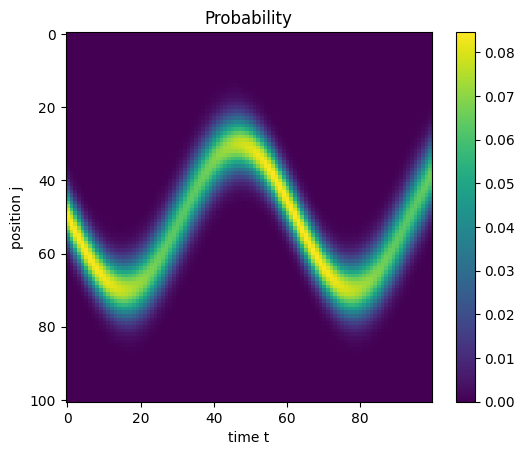

In [20]:
import matplotlib.pyplot as plt
tLst = np.linspace(0, tmax, 100)
final_state = Evolution(init_state, HamGradField, tLst)
prob = np.abs(final_state) ** 2

plt.imshow(prob)
plt.xlabel('time t')
plt.ylabel('position j')
plt.colorbar()
plt.title('Probability')